
# 项目：TMDb电影数据集分析

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

> TMDb数据集中包含 1 万条电影信息，信息来源为“电影数据库”（TMDb，The Movie Database），包括电影名称，总投入，总收入，用户评分，演员，导演，影片类别，用户影评等多个有用变量

> 研究问题1：一共有那些电影类型，2010年以后最受欢迎的电影类别是什么，最受欢迎的类别前五名分别是什么

> 研究问题2：票房高的电影有哪些特点

In [1]:
#导入数据集并查看
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

df_movie = pd.read_csv('tmdb-movies.csv')

<a id='wrangling'></a>
## 数据整理


### 常规属性

In [2]:
df_movie.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [3]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1


### 数据清理(删除缺失值，去掉重复值)

In [4]:
#去掉不需要的列
df_movie.drop(['homepage','keywords','tagline','production_companies'],axis=1,inplace=True)

In [5]:
#去除缺失值
df_movie.dropna(inplace=True)
df_movie.isnull().sum()

id                0
imdb_id           0
popularity        0
budget            0
revenue           0
original_title    0
cast              0
director          0
overview          0
runtime           0
genres            0
release_date      0
vote_count        0
vote_average      0
release_year      0
budget_adj        0
revenue_adj       0
dtype: int64

In [6]:
print(sum(df_movie.duplicated()))

1


In [7]:
#去掉重复值
df_movie.drop_duplicates(inplace=True)
print(sum(df_movie.duplicated()))
df_movie.info()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10724 entries, 0 to 10865
Data columns (total 17 columns):
id                10724 non-null int64
imdb_id           10724 non-null object
popularity        10724 non-null float64
budget            10724 non-null int64
revenue           10724 non-null int64
original_title    10724 non-null object
cast              10724 non-null object
director          10724 non-null object
overview          10724 non-null object
runtime           10724 non-null int64
genres            10724 non-null object
release_date      10724 non-null object
vote_count        10724 non-null int64
vote_average      10724 non-null float64
release_year      10724 non-null int64
budget_adj        10724 non-null float64
revenue_adj       10724 non-null float64
dtypes: float64(4), int64(6), object(7)
memory usage: 1.5+ MB


<a id='eda'></a>
## 探索性数据分析


### 研究问题 1:  一共有那些电影类型，2010年以后最受欢迎的电影类别是什么，最受欢迎的类别前五名分别是什么

In [8]:
#genres这一列按照|切分，整理成列表形式
df_movie['genres'] = df_movie['genres'].apply(lambda x : x.split('|'))

In [9]:
#提取数据集中2010年以后的数据
df_2010 = df_movie.query('release_year > 2010')

In [10]:
#定义电影类型函数
def movietype(df):
    mtype = []
    for movielist in df['genres']:
        mtype = mtype + movielist
    return mtype, list(set(mtype)) # 返回包含df中所有电影类型的列表和df中唯一电影类型的列表

#定义分类别计数函数
def tcounts(list1,list2): #list1是待分类计数的列表，list2是list1中所有的分类唯一值
    typecounts = {}
    typecounts = typecounts.fromkeys(list2,0)
    for i in list1:
        typecounts[i] += 1
    return typecounts

In [11]:
typecounts = tcounts(movietype(df_2010)[0],movietype(df_2010)[1])
#寻找2010年以后最受欢迎的电影类别
for key in typecounts:
    if typecounts[key] == max(typecounts.values()):
        print(key,typecounts[key])

Drama 1241


In [12]:
#寻找2010年以后最受欢迎的电影类别前三名
sorted(typecounts.items(),key = lambda item : item[1], reverse=True)[0:3]

[('Drama', 1241), ('Comedy', 859), ('Thriller', 830)]

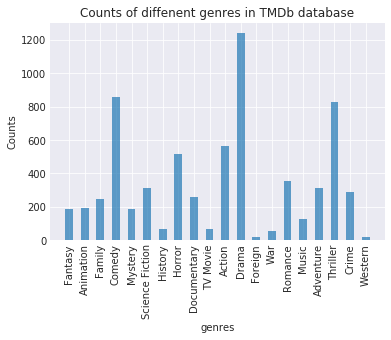

In [13]:
#结果可视化
labels = typecounts.keys()
counts = typecounts.values()
location = np.arange(len(typecounts))
width = 0.5
plt.bar(location,counts,width, alpha = 0.7)
plt.ylabel('Counts')
plt.xlabel('genres')
plt.title('Counts of diffenent genres in TMDb database')
plt.xticks(location, labels, rotation=90);

### 研究问题 2：票房高的电影有哪些特点

In [14]:
print(df_movie['revenue'].describe())

count    1.072400e+04
mean     4.034621e+07
std      1.176863e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.500980e+07
max      2.781506e+09
Name: revenue, dtype: float64


由于最小值和50%分位数均为0，75%分位数大于0，所以数据集中半数以上的电影票房为0，不具有研究价值，下面仅提取票房大于0的样本进行分析

In [15]:
revenue_pos = df_movie.query('revenue > 0') #生成票房大于0的子数据集
print(revenue_pos['revenue'].describe())

count    4.843000e+03
mean     8.933981e+07
std      1.621546e+08
min      2.000000e+00
25%      7.779664e+06
50%      3.191160e+07
75%      1.000000e+08
max      2.781506e+09
Name: revenue, dtype: float64


In [16]:
bin_edges = [2.00e+00,7.78e+06,1.00e+08,2.79e+09] #按照四分位数的值进行分组
bin_names = ['低','中','高']
revenue_positive = revenue_pos.copy() #将内容增加到数据框上面去前，需要将数据框拷贝一下，否则会弹出A value is trying to be set on a copy of a slice from a DataFrame.  
revenue_positive['revenue_levels']  = pd.cut(revenue_pos['revenue'], bin_edges, labels=bin_names)
revenue_positive.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,director,overview,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,revenue_levels
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,Twenty-two years after the events of Jurassic ...,124,"[Action, Adventure, Science Fiction, Thriller]",6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,高
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,An apocalyptic story set in the furthest reach...,120,"[Action, Adventure, Science Fiction, Thriller]",5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,高
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,Beatrice Prior must confront her inner demons ...,119,"[Adventure, Science Fiction, Thriller]",3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08,高
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,Thirty years after defeating the Galactic Empi...,136,"[Action, Adventure, Science Fiction, Fantasy]",12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09,高
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,Deckard Shaw seeks revenge against Dominic Tor...,137,"[Action, Crime, Thriller]",4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09,高


In [17]:
#按照票房高低分组
re_high = revenue_positive.query('revenue_levels == "高"')
re_median = revenue_positive.query('revenue_levels == "中"')
re_low = revenue_positive.query('revenue_levels == "低"')

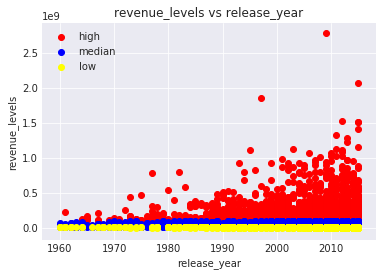

In [18]:
#考察票房高低与电影发行时间的关系
plt.scatter(x=re_high['release_year'],y=re_high['revenue'],color='red')
plt.scatter(x=re_median['release_year'],y=re_median['revenue'],color='blue')
plt.scatter(x=re_low['release_year'],y=re_low['revenue'],color='yellow')
plt.xlabel('release_year')
plt.ylabel('revenue_levels')
label=['high','median','low']
plt.legend(label)
plt.title('revenue_levels vs release_year')
plt.show();

票房高的电影发行时间越往后，票房有越高的趋势，票房低和票房中等的电影发行时间和票房没有明显关联

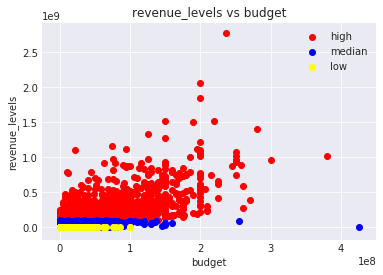

In [19]:
#考察票房高低与预算投入的关系
plt.scatter(x=re_high['budget'],y=re_high['revenue'],color='red')
plt.scatter(x=re_median['budget'],y=re_median['revenue'],color='blue')
plt.scatter(x=re_low['budget'],y=re_low['revenue'],color='yellow')
plt.xlabel('budget')
plt.ylabel('revenue_levels')
label=['high','median','low']
plt.legend(label)
plt.title('revenue_levels vs budget')
plt.show();

票房高的电影在一定范围内投入预算增加，票房有增多的趋势，票房低和票房中等的电影预算与票房没有明显关联

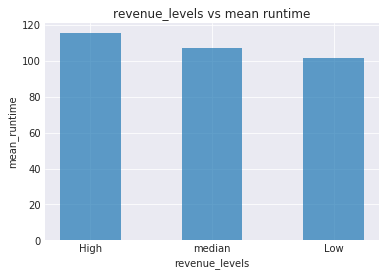

In [20]:
#考察票房高低与电影平均播放时长的关系
t_h = re_high['runtime'].mean()
t_m = re_median['runtime'].mean()
t_l = re_low['runtime'].mean()
plt.bar([0,0.2,0.4],[t_h,t_m,t_l], width=0.1, alpha = 0.7, tick_label=['High','median','Low'])
plt.ylabel('mean_runtime')
plt.xlabel('revenue_levels')
plt.title('revenue_levels vs mean runtime')
plt.show();

票房从高到低，电影平均播放时长逐渐减少

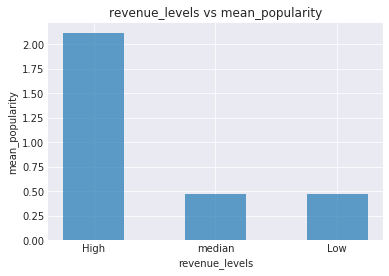

In [21]:
#考察票房高低与观影人数的关系
p_h = re_high['popularity'].mean()
p_m = re_low['popularity'].mean()
p_l = re_low['popularity'].mean()
plt.bar([0,0.2,0.4],[p_h,p_m,p_l], width=0.1, alpha = 0.7, tick_label=['High','median','Low'])
plt.ylabel('mean_popularity')
plt.xlabel('revenue_levels')
plt.title('revenue_levels vs mean_popularity')
plt.show();

票房高的电影观影人数比票房中等和低的观影人数多很多，近似三倍以上，票房中等和票房低的电影观影人数相近

In [22]:
#考察票房高低与电影类别的关系
h_typecounts = tcounts(movietype(re_high)[0],movietype(re_high)[1])
m_typecounts = tcounts(movietype(re_median)[0],movietype(re_median)[1])
l_typecounts = tcounts(movietype(re_low)[0],movietype(re_low)[1])

In [23]:
keylist = set(list(h_typecounts.keys()) + list(m_typecounts.keys()) + list(l_typecounts.keys())) # 生成票房分类样本中所有电影类别的列表
def add0(df): #定义一个函数，检验字典中是否包含keylist中所有的键，如果没有，赋值为0
    for i in keylist:
        if i not in df.keys():
            df[i] = 0
    return df

def sortbykey(df): #定义一个函数，对字典按照键值及逆行排序
    sortdict = {}
    for k in sorted(df.keys()):
        sortdict[k] = df[k]
    return sortdict

h_typecounts = sortbykey(add0(h_typecounts))
m_typecounts = sortbykey(add0(m_typecounts))
l_typecounts = sortbykey(add0(l_typecounts))

In [24]:
h_typecounts.keys() == m_typecounts.keys() == l_typecounts.keys()

True

In [25]:
ind = np.arange(len(h_typecounts))  # 组的 x 坐标位置
width = 0.2       # 条柱的宽度

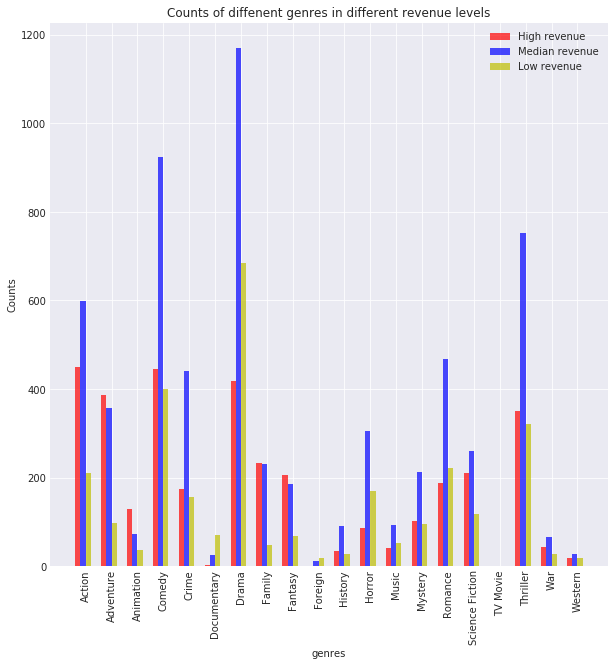

In [26]:
#设置画布大小
plt.figure(figsize=(10,10))

# 绘制条柱
high_bars = plt.bar(ind, h_typecounts.values(), width, color='r', alpha=.7, label='High revenue')
median_bars = plt.bar(ind + width, m_typecounts.values(), width, color='b', alpha=.7, label='Median revenue')
low_bars = plt.bar(ind + width + width, l_typecounts.values(), width, color='y', alpha=.7, label='Low revenue')

# 标题和标签
plt.ylabel('Counts')
plt.xlabel('genres')
plt.title('Counts of diffenent genres in different revenue levels')
locations = ind + width + width / 2  # x 坐标刻度位置
labels = h_typecounts.keys()  # x 坐标刻度标签
plt.xticks(locations, labels, rotation=90)

# 图例
plt.legend();

票房中等亚类的电影类型计数差别最大，票房低亚类次之，票房高亚类计数差别最小；

三类样本中电影类型计数最多的均为Drama，Comedy和Action，票房高亚类中电影类型计数最高的是Action，票房中等亚类和票房低亚类均是Drama；

票房高亚类在Animation类型电影中占主导，计数明显高于其他两个亚类

<a id='conclusions'></a>
## 结论

### 研究问题1
    2010年以后的电影类型有'Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family',
    'Fantasy','Foreign','History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','
    Thriller','War'和'Western'

    2010年以后最受欢迎的电影类别是Drama

    2010年以后最受欢迎的电影类别前三名是Drama，Comedy，Thriller

### 研究问题2
     票房高的电影发行时间越往后，票房有越高的趋势，票房低和票房中等的电影发行时间和票房没有明显关联；
     
     票房高的电影在一定范围内投入预算增加，票房有增多的趋势，票房低和票房中等的电影预算与票房没有明显关联；

     票房从高到低，电影平均播放时长逐渐减少；

     票房高的电影观影人数比票房中等和低的观影人数多很多，近似三倍以上，票房中等和票房低的电影观影人数相近；

     票房中等亚类的电影类型计数差别最大，票房低亚类次之，票房高亚类计数差别最小；
     
     三类样本中电影类型计数最多的均为Drama，Comedy和Action，票房高亚类中电影类型计数最高的是Action，票房中等亚类和低亚类均是Drama；
     
     票房高亚类在Animation类型电影中占主导，计数明显高于其他两个亚类
     
## 局限性
    1.问题2中票房高低的分类是按照四分位数为界进行划分的，分类方式不同可能产生不同的分析结果；
    
    2.问题2中票房变量与发行时间，电影类型等变量通过可视化的方式进行定性比较，只能判断大致的相关趋势，没有经过统计学检验
    
    3.问题2中票房变量与其他变量之间相关性的分析都是一对一，没有进行一对多的相关分析
    
    4.数据预处理部分缺失值是直接删除的，可能由填充等其他处理方式
    
    5.问题1中选取的是2010年后的数据，没有对完整数据集进行分析，分析结果可能有局限

<a id='references'></a>
## 参考文献
     无

In [27]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255